# Gym Data Analysis

# Author: James Amezcua

# Introduction

This report presents the analysis of data from gym chain: Model Fitness. In the data, we are provided with information on customer churn in a given month and the customer profile data on the month preceding it. The ultimate goal of the analysis is to provide insights and possible interaction strategies to reduce churn rate among Model Fitness customers. To that end, we will:

- develop machine learning algorithms to predict the probability of churn for each customer in the coming month;
- analyze the factors that impact churn most;
- draw up typical user portraits: which group is outstanding and which group should we be concerned with;
- provide recommendations on how to improve customer service; and
- suggest measures to cut churn

In what follows, we will first import and check the data, then carry out both supervised and unsupervised machine learning algorithms to address the key tasks above.

# Table of content

Part 1: Data importing

Part 2: Exploratory data analysis

Part 3: Data preprocessing

Part 4: Predicting user churn

Part 5: Identifying user clusters

Part 6: Findings and conclusions

In [1]:
#Downloading the packages needed
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('colorblind')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Part 1: Data importing

In [2]:
#inport data and check the first 5 rows
gym_data = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn_us.csv')
gym_data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Let's first check the general information of the data.

In [3]:
#check data information
gym_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [4]:
#check data shape
gym_data.shape

(4000, 14)

We can tell from the above that there are a total of 13 features available in the data, and 4000 observations, which could be considered decent to carry out machine learning tasks.

In [5]:
#check for null values
gym_data.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [6]:
#check for duplicates
gym_data.duplicated().sum()

0

There are no missing values or duplicates in the data. Our data is very healthy! Later in the exploratory data analysis stage we will further check on data quality, particularly in terms of noise, error, outliers, and distribution, to see what preprocessing will be necessary to get the data ready for machine learning tasks.

# Part 1 Summary

Data checking in this section shows that:

- we have a total of 13 features available for use;
- data size is decent for machine learning purposes; and
- the data doesn't contain missing values or duplicates.

It's also important to note that, the data does not have time relations. We do not know when the profile information from each customer was collected and they are independent from one another. All we know is that the information precedes the customer churn information.

Given the task at hand is to predict customer churn in the coming month, later when we are developing the machine learning algorithms, we can justify the decision to use random splitting method to split the training and validation dataset, which will give us a training data structure similar to the data for which the algorithms will be used.

# Part 2: Exploratory data analysis

In this section, we will perform the following exploratory analysis:

- examine the mean values and standard deviation for the features in the data;

- compare the mean feature values in two groups: for those who left (churn) and for those who stayed;

- plot the feature distributions for those who left and those who stayed; and

- build a correlation matrix of the dataset.

In [7]:
#let's first change the column names to all lower case
gym_data.columns = gym_data.columns.str.lower()

In [8]:
#check the first 5 rows again
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


From the first five rows we can gather that 'contract_period' seems like a categorical variable with more than 2 levels, whereas features including 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits' are binary categorical variables.

# Examine the feature values 

As a first step, we will single out 'contract_period' to be examined using value_counts(), then use describe() to study the rest of the feature values as well as the target variable 'churn'.

In [9]:
gym_data['contract_period'].value_counts()

1     2207
12     960
6      833
Name: contract_period, dtype: int64

Yes indeed, there are three levels to 'contract_period'. Customers join the gym on either a 1 month, 6 months or 12 months contract. Majority sign up for the 1 month membership.

In [10]:
#check the values for rest of the columns
gym_data.drop('contract_period', axis=1).describe().loc[['mean', 'std', 'min', 'max']].T

,mean,std,min,max
gender,0.510250,0.499957,0.000000,1.000000
near_location,0.845250,0.361711,0.000000,1.000000
partner,0.486750,0.499887,0.000000,1.000000
promo_friends,0.308500,0.461932,0.000000,1.000000
phone,0.903500,0.295313,0.000000,1.000000
group_visits,0.412250,0.492301,0.000000,1.000000
age,29.184250,3.258367,18.000000,41.000000
avg_additional_charges_total,146.943728,96.355602,0.148205,552.590740
month_to_end_contract,4.322750,4.191297,1.000000,12.000000
lifetime,3.724750,3.749267,0.000000,31.000000


From the above information we can tell that majority of the customers live in the neighbourhood of the gym(84.5%), and have their phone number recorded (90.3%). The customers is relatively gender balanced (51%), and close to half (48.6%) are employees of a gym partner company. It's also interesting to notice that approximately 30% of the customers joined the gym through the 'bring a friend' offer, and less than half (41.2%) have joined a group class.

For features of numeric values, we can see the average age of a gym member is 29, with the maximum age of only 41. It's a gym with relatively young membership. The average additional spend is approximately 146, with high variation. The average lifetime of the members is close to 4 months, also with a high variation. Those who have stayed with the gym longest have been there for as long as 31 months.

It's interesting to note the average class frequency both in the current month and total is close to but not quite 2 classes per week, also with a relatively high variation.

Last, it's important to notice that the churn rate overaall is slightly over 26%. Our binary target variable values are not distributed evenly. The customers in the data who didn't quit almost triple the size of those who did. We have to keep this in mind when later develop our algorithms.

Next, let's take a look at how the average values of features vary between the customers who quit and who didn't.

# Feature values between the churn and nonchurn group

In [11]:
gym_data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


We can see from the above that, among those who quit the gym, there is a relatively lower proportion of members living close by, having been brought in by a friend, being a partner company employee, and having joined a group class. They also have a shorter average gym contract period than those who didn't quit, a lower average extra spending, a shorter lifetime, and lower average frequency of attending classes per week.

This indicates that those features in particular: 'near_location', 'partner', 'promo_friends', 'contract_period', 'group_visits', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', and 'avg_frequency_class_current_month', will be useful predictors for customer churn.

Next let's plot the distribution of the features to have a more visual examination of them.

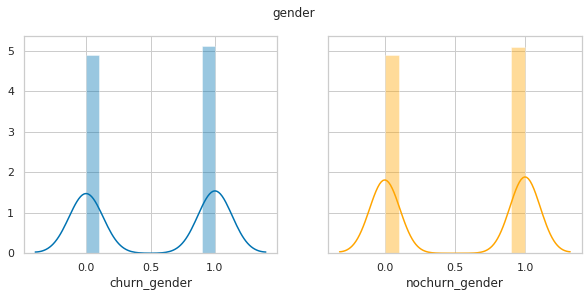

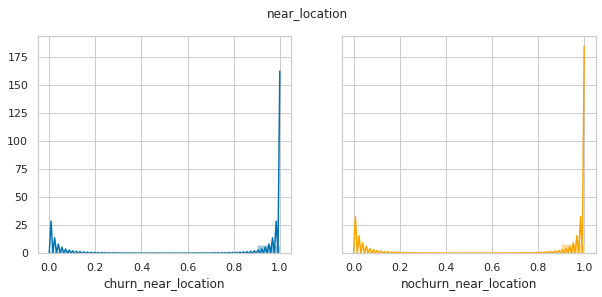

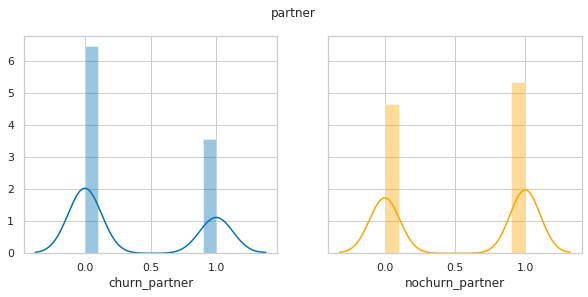

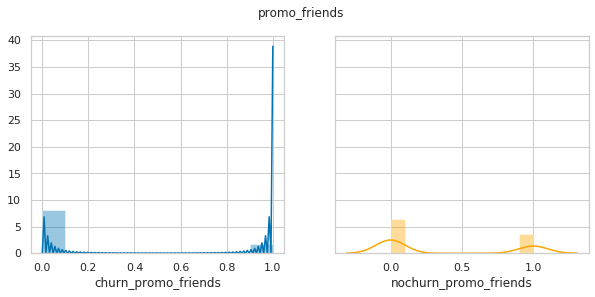

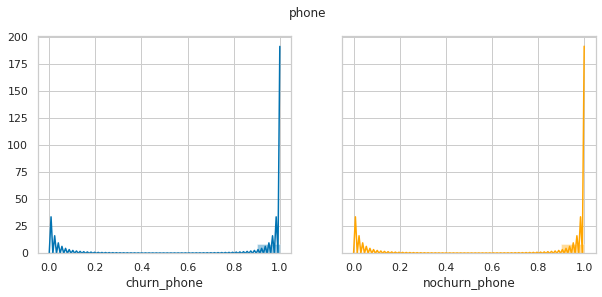

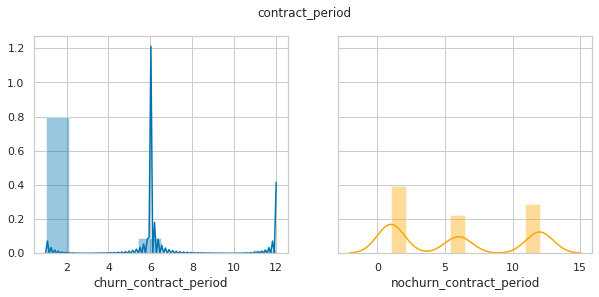

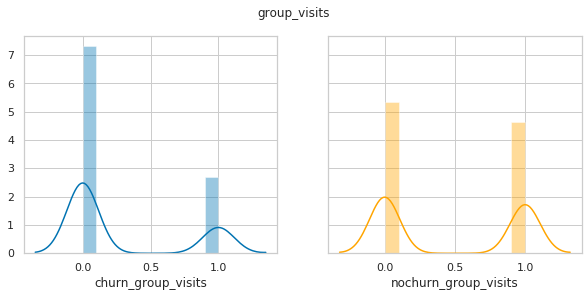

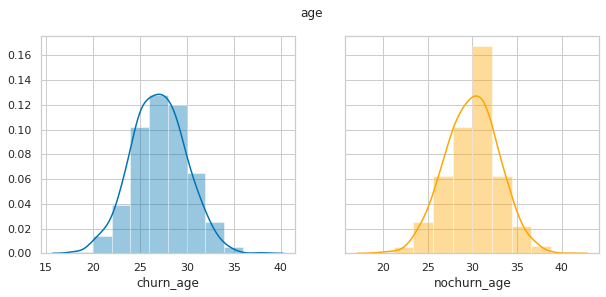

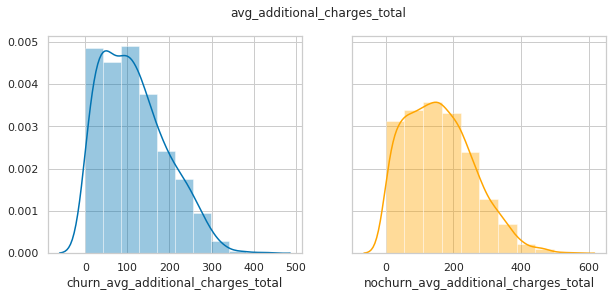

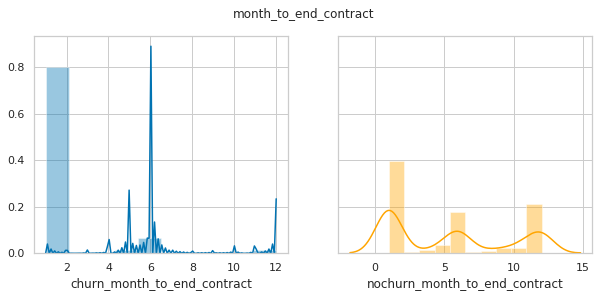

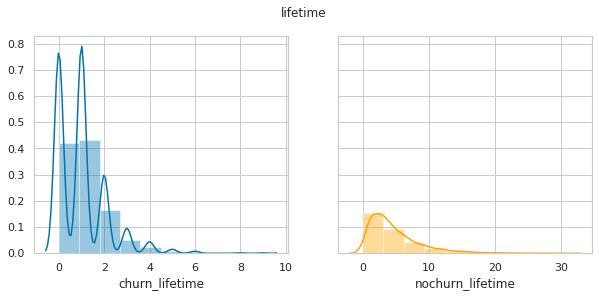

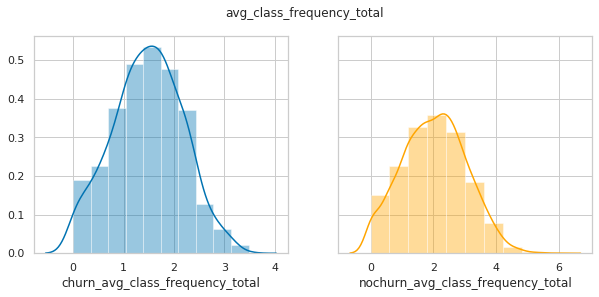

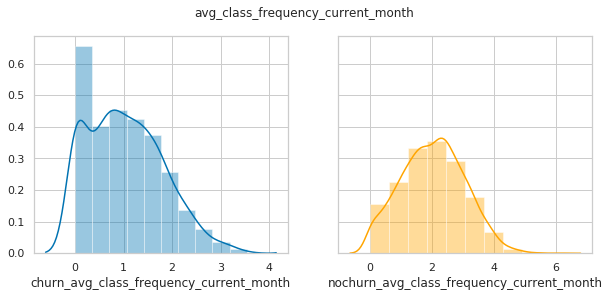

In [12]:
for feature in gym_data.drop('churn', axis=1).columns:
    fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 4))
    sns.distplot(gym_data.query('churn ==1')[feature], bins=10, ax=ax1)
    ax1.set_xlabel('_'.join(['churn', feature]))
    sns.distplot(gym_data.query('churn ==0')[feature], bins=10, ax=ax2, color='orange')
    ax2.set_xlabel('_'.join(['nochurn', feature]))
    plt.suptitle(feature)
    plt.show()

As we can see from the graphs above, the most obvious divide between the customers who quit and those who stayed occur in 'partner', 'promo_friends', 'contract_period', 'group_visits', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', and 'avg_frequency_class_current_month'. These results are consistent with our earlier discusson on the average feature values between the two groups.

Next, let's let a look at how the features are correlated with the target variable, as well as with one another.

# Correlation matrix

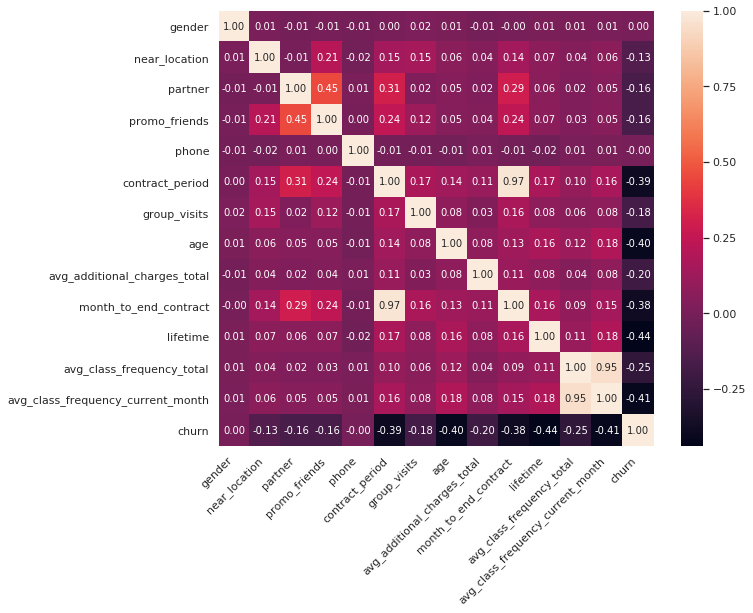

In [13]:
#plotting the correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(gym_data.corr(), annot=True, square=True, fmt='.2f')
plt.xticks(rotation=45, ha='right')
plt.show()

From the heatmap above we can see that, 'contract_period'(-0.39), 'life_time(-0.44), 'age'(-0.4), 'month to end contract'(-0.38), and 'average_class_frequency_current_month'(0.41) seem to have a relatively higher correlation with on customer churn than other features. It's interesting to see 'age' here because the mean feature values and plots didn't show the churn and nonchurn groups vary much.

We can also see that 'month_to_end_contract' and 'contract_period' are highly correlated, so are 'avg_class_frequency_total' and 'avg_class_frequency_current_month'. To get a closer look at how these features are correlated, let's build a scatterplot for each pair.

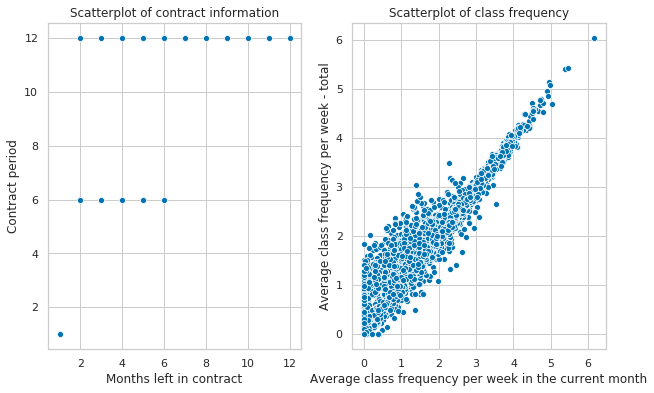

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 6))
sns.scatterplot(gym_data['month_to_end_contract'], 
                     gym_data['contract_period'], ax=ax1)
sns.scatterplot(gym_data['avg_class_frequency_current_month'], 
                     gym_data['avg_class_frequency_total'], ax=ax2)

ax1.set_title('Scatterplot of contract information')
ax1.set_xlabel('Months left in contract')
ax1.set_ylabel('Contract period')

ax2.set_title('Scatterplot of class frequency')
ax2.set_xlabel('Average class frequency per week in the current month')
ax2.set_ylabel('Average class frequency per week - total')
plt.show()


We can see from the above scatterplots that, contract period does decide how many months the customers have left in their current contract, but not in the same linear manner as how the average class frequency per week in the current month and that in total are related.

To fit a logistic regression and random forest model later in the analysis, we do need to remove the multicollinearity among the features. In this case, we will choose to keep 'avg_class_frequency_current_month' and remove 'avg_class_frequency_total' as the former shows a slightly higher correlation with customer churn (-0.41 v.s -0.25).

'contract_period' and 'month_to_end_contract' are also highly correlated related, but they are not the same features and we can argue that the number of months left in the contract might affect decision to churn in different ways as the total duration of the contract. In order not to lose valuable information, we will keep both. Of course, ideally we can compare the models with and without one of them to see if its accuracy can be improved.

# Part 2 summary

he exploratory analysis in this sections shows:

there are no obvious outliers in the data;

among the 13 features, 6 are binary variables, 6 are numeric variables, and there is 1 that is a categorical variable with 3 levels: 'contract_period';

there are two sets of highly correlated variables, which are 'avg_class_frequency_total' and 'avg_class_frequency_current_month', and 'month_to_end_contract' and 'contract_period';

mean feature values and graphs show that the features that differ most obviously between the churn and nonchurn customers are: 'partner', 'promo_friends', 'contract_period', 'group_visits', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', and 'avg_frequency_class_current_month';

correlation matrix shows that'contract_period', 'month_to_end_contract', 'life_time, 'age', and 'average_class_frequency_current_month' have a relatively higher correlation to customer churn than other features.

In the next section, we will preprocess the dataset to get it ready for carrying out the machine learning algorithms.

# Part 3: Data preprocessing 

In this section, we will perform two straightforward tasks:

- change the multilevel categorical feature 'contract_period' to 3 binary columns;
- standardize the features to prepare them for machine learning algorithms.

In [15]:
#check the data again
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Next, let's transform the dataframe so that each category column is binary. In our case, we only need to transform the 'contract_period' column.

# Transform the categorical column

In [16]:
gym_data_transformed = pd.get_dummies(gym_data, columns =['contract_period'])
gym_data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
contract_period_1                    4000 non-null uint8
contract_period_6                    4000 non-null uint8
contract_period_12            

# Standardize the numeric data

First, as mentioned earlier on, we will drop 'avg_class_frequency_total', and split the dataframe into features: X, and target variable: y. We will keep all other features in our first attempt to fit machine learning models.

In [17]:
X = gym_data_transformed.drop(['churn','avg_class_frequency_total'], axis=1)
y = gym_data_transformed['churn']

Then let's split the data into training and validation sets.

When choosing the method to split the data, we take into account the fact that the observations in the data provided are independant from one another, hence the prediction of customer churn is independant as well. Moreover, we have no knowledge of when the customer information is collected. All we have is whether they quit the gym or not and their profile information in the preceding month.

Therefore, a random splitting method is the most suitable way to split the training and validation dataset.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

We will prepare two sets of training and test data, raw and standardized.

For the logistic regression model, although the model is not sensitive to the mignitute of the variables, we will still use standardize feature values as we want to take a look at the information of feature coefficients.

For developing the random forest model, we will just use the raw data as the model is not sensitive to the magnitude of the variables.

Later in the cluster analysis, we will also use the standardized datasets as clustering models are distance based algorithms, but we will use the whole feature dataset for that purpose.

In [19]:
# Train and apply the "standardizer" on the train set, then apply to validation set
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [20]:
#take a look at the first five values
X_train_st[:,5]

array([-0.84769226, -0.84769226, -0.84769226, ..., -0.84769226,
        1.17967339,  1.17967339])

Let's check the mean and standard deviation of the standardized training and validation data.

In [21]:
print('mean and standard deviation of training data\n',
      X_train_st.mean(), X_train_st.std())

print('mean and standard deviation of validation data\n',
      X_test_st.mean(), X_test_st.std())

mean and standard deviation of training data
 -5.075305255429287e-18 0.9999999999999999
mean and standard deviation of validation data
 -0.013076768139053941 1.006729855660226


As we would expect, the validation data standardized using the model trained on training data has a mean not exactly 0 but close, and a close to 1 standard deviation as well.

# Part 3 summary

Now we are ready to carry out the machine learning tasks on the data.

# Part 4: Predicting user churn

In this seciton, we will:

build a binary classification model for customers where the target feature is the user's leaving next month with both logistic regression and random forest method;

evaluate the accuracy, precision, and recall for both models using the validation data;

compare the two models to see which one gives better results; and

evaluate the importance of features when predicting user churn.

# 4.1 Build a logistic regression model

To fit the best logistic regression model, we will first search for the suitable hyperparameters in order to achieve best results. Logistic regression model doesn't have any critical hyperparameters to tune but we will experiment with different solvers and c values.

We also need to decide on what key metrics we will use to evaluate our model. Given the data has an unbalanced churn and nonchurn outcomes, accurary score is not the most suitable. The choice of metric of course depends on business goals. In our case, we can imagine that the gym will need to spend resources trying to retain customers, therefore each additional churn prediction might cost gym.

Given that consideration, to focus on resouces on where it is most needed, a high precision score would be more useful. Therefore, although we will be calculating all major metrics, accuracy, precision, recall, and roc_auc score, precision score is the basis for our fine tuning of hyperparameters.

# The model

In [23]:
#Let's find out with what hyperparameter give the best model results.
lg_model = LogisticRegression(random_state=0)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers, C=c_values)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator=lg_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='precision', error_score=0)
grid_result = grid_search.fit(X_train_st, y_train)

In [24]:
#find out which hyperparameters result in the highest precision score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.861395 using {'C': 0.01, 'solver': 'newton-cg'}


In [25]:
# define the model's algorithm using the best parameters
lg_model = LogisticRegression(C=0.01, solver='newton-cg',
                              random_state=0)
# train the model
lg_model.fit(X_train_st, y_train)

# use the trained model to make forecasts
y_pred = lg_model.predict(X_test_st)
lg_probabilities = lg_model.predict_proba(X_test_st)[:, 1]

In [26]:
#Let's also get the predictions on the training data
y_train_pred = lg_model.predict(X_train_st)
lg_probabilities_train = lg_model.predict_proba(X_train_st)[:, 1]

# Importance of features

,feature,weights
0,gender,0.032850
1,near_location,-0.075234
2,partner,-0.079632
3,promo_friends,-0.135944
4,phone,-0.035421
5,group_visits,-0.221926
6,age,-0.695269
7,avg_additional_charges_total,-0.348294
8,month_to_end_contract,-0.329225
9,lifetime,-1.231072


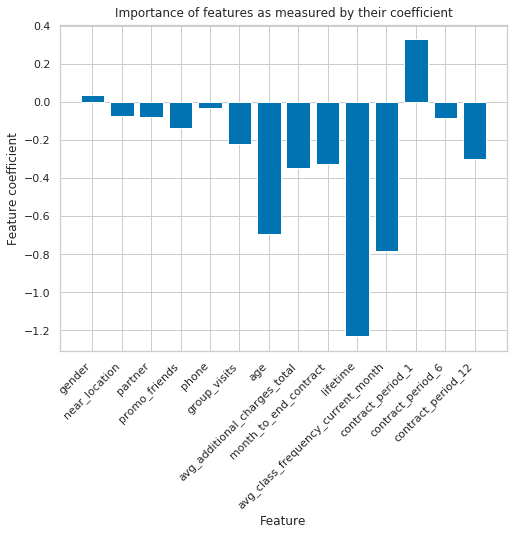

In [27]:
# find the feature coefficients
importance = lg_model.coef_[0]

# summarize feature importance
feature_importance = pd.DataFrame(
    {'feature': X.columns, 'weights': importance})
display(feature_importance)

# plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(X.columns, importance)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Feature coefficient')
plt.xlabel('Feature')
plt.title('Importance of features as measured by their coefficient', pad=8, size=12)
plt.show()

The positive scores above indicate a feature that predicts class 1, which is that the customer will quit the next month; whereas the negative scores indicate a feature that predicts class 0, the customer will stay.

The most important features to indicate the customer will stay, as we can tell from the graphs, are:

- life_time,
- avg_class_frequency_current_month, and interestingly,
- age

The most deciding feature to predict a 
customer will churn next month is "contract_period_1", which makes sense. They finish their 1 month contract and are not obligated to stay in the month after unless they want to renew.

# Information on metrics

Let's get the key metrics calculation for both training and validation data so we can also find out if the model overfits or underfits.

In [28]:
#get the confusion matrix for validation data
cm_test = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm_test.ravel() 

In [29]:
print(tn, fp, fn, tp)

571 31 42 156


In [30]:
#get the confusion matrix for training data
cm_train = confusion_matrix(y_train,y_train_pred)
tn, fp, fn, tp = cm_train.ravel()  
print(tn, fp, fn, tp)

2229 108 193 670


Above we get the information on the number of true negatives, false positives, false negatives, and true positives for using the model on both the training and test data.

Next let's have a look at the key metrics scores.

In [31]:
# metrics score for the training data
acc_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, lg_probabilities_train)

print('Metrics score for the training data:')
print(
    "accuracy score: {0}; \nprecision score: {1}; \nrecall score: {2}; \nroc_auc score: {3}".format(acc_train, precision_train, recall_train, roc_auc_train))


Metrics score for the training data:
accuracy score: 0.9059375; 
precision score: 0.8611825192802056; 
recall score: 0.776361529548088; 
roc_auc score: 0.9624777683405303


In [32]:
# metrics score for the validation data
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, lg_probabilities)

print('Metrics score for the validation data:')
print(
    "accuracy score: {0}; \nprecision score: {1}; \nrecall score: {2}; \nroc_auc score: {3}".format(acc, precision, recall, roc_auc))

Metrics score for the validation data:
accuracy score: 0.90875; 
precision score: 0.8342245989304813; 
recall score: 0.7878787878787878; 
roc_auc score: 0.9612738682506126


Overall, the logistic regression model did well in achieving a decent precision score, which is what we want. The precision score for the training data is slightly higher(0.86) than that for the validation data(0.83), but not bad.

The roc_auc score also is pretty high at 0.96, which indicates our model has a good quality. But we can still plot to examine how well the model does to distinguish the 2 classes.

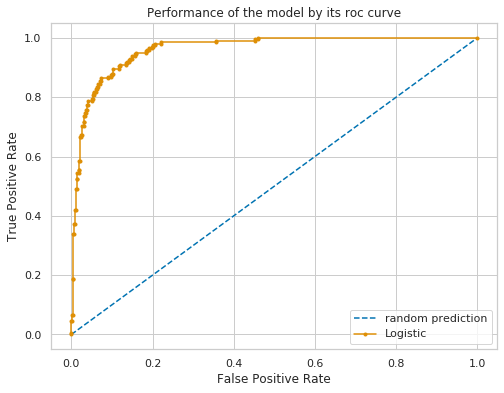

In [33]:
plt.figure(figsize=(8,6))
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='random prediction')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, lg_probabilities)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Performance of the model by its roc curve')
plt.legend()
plt.show()

The higher the line curves in the direction of the upper left corner, i.e. the closer it is to 1, the better. In our case, the roc curve is really pushing to the upper left corner. We have got a decent model!

# 4.2 Build a random forest model

Let's first take a look at the hyperparameters in a random forest model

In [34]:
rf_model = RandomForestClassifier(random_state=42)
print('Parameters currently in use:\n')
print(rf_model.get_params())

Parameters currently in use:

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In the model we are trying to fit, we will experiment with 4 hyperparameters: bootstrap, max_features, criterion, and n_estimators.

In [35]:
param_grid = {'bootstrap': [True, False],
              'max_features': ['none', 'sqrt', '0.3'],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 50, 100, 200]}

Next, let's find out the best hyperparameters. We will still use precision score as the key metric to choose the hyperparameters. For random forest model, we will use the raw values from the data.

In [37]:
#using GridSearchCV to find the best hyperparameters
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           n_jobs=-1, cv=cv, scoring='precision',
                           error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [38]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.841892 using {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 200}


# The model

Now, let's use the above best hyperparameters to fit the random forest model. Although random forest model is rather robust against overfitting. We will still compare the key metrics score between the training and validation data.

In [39]:
rf_model = RandomForestClassifier(random_state=0,
                                  bootstrap=True,
                                  criterion='entropy',
                                  max_features='sqrt',
                                  n_estimators=10)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]
rf_probabilities_train = rf_model.predict_proba(X_train)[:, 1]

# Information on key metrics

In [40]:
# metrics score for the training data
acc_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, lg_probabilities_train)

print('Random forest model metrics score for the training data:')
print(
    "accuracy score: {0}; \nprecision score: {1}; \nrecall score: {2}; \nroc_auc score: {3}".format(acc_train, precision_train, recall_train, roc_auc_train))

Random forest model metrics score for the training data:
accuracy score: 0.993125; 
precision score: 0.9952885747938751; 
recall score: 0.9791425260718424; 
roc_auc score: 0.9624777683405303


The metrics score on the training data is a little usually high. Let's look at those on the validation data.

In [42]:
# metrics score for the validation data
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, lg_probabilities)

print('Random forest model metrics score for the validation data:')
print(
    "accuracy score: {0}; \nprecision score: {1}; \nrecall score: {2}; \nroc_auc score: {3}".format(acc, precision, recall, roc_auc)) 

Random forest model metrics score for the validation data:
accuracy score: 0.89125; 
precision score: 0.8032786885245902; 
recall score: 0.7424242424242424; 
roc_auc score: 0.9612738682506126


For the validation dataset, we still received a high roc_auc score, which indicates that our model is of good quality. The precision score, which we consider key in this case, is slightly over 0.80, a lot lower than the precision score from the training data. Our model actually was overfitted.

Comparing the random forest model with the logistic regression model, the latter has a little higher precision score (0.83). If we are to use similar data to predict customer churn, the logistic regression model is a good one to go with.

# Importance of features

Now let's take a look at the ranking of features by their importance.

In [43]:
#get the feature importance from the random forest model into a dataframe
importances = pd.DataFrame(
    {'feature': X.columns, 'importance': rf_model.feature_importances_})

print(importances.sort_values(by='importance', ascending=False))

                              feature  importance
9                            lifetime    0.249418
10  avg_class_frequency_current_month    0.236923
6                                 age    0.143891
7        avg_additional_charges_total    0.122660
11                  contract_period_1    0.063944
8               month_to_end_contract    0.055917
5                        group_visits    0.024340
3                       promo_friends    0.018738
13                 contract_period_12    0.018059
1                       near_location    0.016284
2                             partner    0.014883
0                              gender    0.013837
4                               phone    0.010800
12                  contract_period_6    0.010307


We can see from the above that, similar to results from the logistic regression model, 'lifetime', 'avg_class_frequency_current_month', and 'age' seems to be the most important features to predict user churn.

# Part 4 summary

In this section, we used the method of logistic regression and random forest to have built a binary classification model to predict customer churn. Comparing the key metrics score between the two methods, in particular using the precision score, we can conclude that the logistic regression model performed slightly better.

As revealed by both models, 'lifetime', 'avg_class_frequency_current_month', and 'age' stand out as the most influential features to predict user churn.

# Part 5: Identifying user clusters 

In this section, we will:

- plot a dendrogram to identify user clusters;

- train the clustering model with the K-means algorithm and predict customer clusters(clusters will be set as n=5 for easy comparison);

- examine the mean feature values for clusters;

- calculate the churn rate for each cluster to find out which cluster is more prone to quitting and which one is loyal; and

- plot distributions of features for the clusters.

In [44]:
#standardize the features, here we will bring back all the features 
sc = StandardScaler()
X_sc = sc.fit_transform(gym_data_transformed.drop('churn', axis=1))
linked = linkage(X_sc, method = 'ward') 

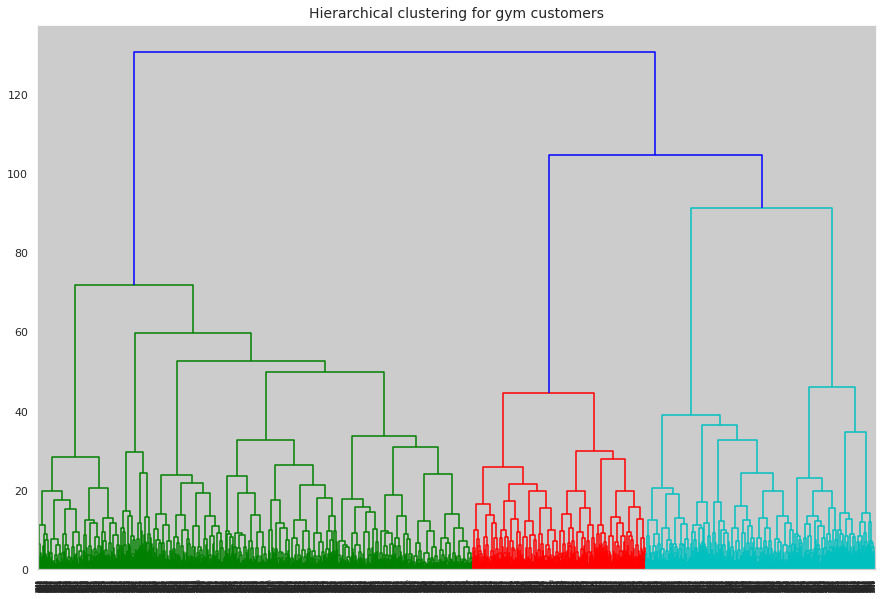

In [45]:
#plot the dendrograms
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for gym customers', size=14, pad=8)
plt.show() 

The dendrograms above naturally reveal three clusters, the yellow, the green, and the orange clusters. When training the clustering model with the K-means algorithm, it would be very reasonable to set n_clusters as 3. However, in our case, we will set n_clusters as 5 as requested by the task.




In [46]:
km = KMeans(n_clusters = 5, random_state=42) # setting the number of clusters as 5
labels = km.fit_predict(X_sc) 
gym_data['cluster_km'] = labels

In [47]:
#check the data again
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,1
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,2
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,1
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,2


In [48]:
#Get the mean feature values by cluster, ranked by churn rate from highest
gym_data.groupby('cluster_km').mean().sort_values(by='churn', ascending=False)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
2,0.476699,1.000000,0.337864,0.224272,0.907767,1.000000,0.318447,27.954369,125.784256,1.000000,2.117476,1.242521,0.962749,0.614563
3,0.513889,0.000000,0.428241,0.071759,0.907407,1.000000,0.192130,28.361111,130.681467,1.000000,2.564815,1.672497,1.449441,0.520833
0,0.516827,0.861779,0.575721,0.375000,0.895433,6.000000,0.442308,29.544471,151.379994,5.617788,4.137019,1.941094,1.887587,0.125000
4,0.549598,0.990617,0.332440,0.270777,0.904826,1.006702,0.465147,30.143432,159.206701,1.004021,4.946381,2.634425,2.618263,0.101877
1,0.508333,0.932292,0.715625,0.477083,0.903125,12.000000,0.544792,29.816667,163.589978,10.839583,4.664583,2.014054,2.007001,0.023958


There is quite obvious differences in churn rate among the clusters, with cluster 0 has a churn rate over 60%, whereas cluster 2 has a churn rate of as low as 2%.

The most noticeable differences in features include:

- cluster 0 has the actually have the highest rate (1!) of customers living in the neighbourhood of the gym;

- cluster 0 has the lowest rate of customers being employees of a partner company, whereas cluster 2 is the opposite;

- proportion of customers who signed up through 'bring a friend' offer is the second lowest among cluster 0, and the highest among cluster 2;

- cluster 0 has the shortest contract period, together with cluster 4 whereas cluster 2 has the longest 12 months in average;

- cluster 0 has the second lowest average frequency of group visits, whereas cluster 2 has the highest;

- cluster 0 is also the youngest on average compared with all other clusters;

- cluster 0 accounts for the least amount of additional charge on average, where cluster 2 accounts for the largest in this aspect;

- cluster 0 has the shortest month to end contract together with cluster 4, whereas cluster 2 has the longest. However, this can be easily understood because the two clusters' contract periods are different in the first place;

- lifetime wise, cluster 0 has the shortest on average, slightly over 2 months, while cluster 1 has, on average, 4.66 months, ranking the second highest among all the clusters.

- for both average class frequency per week during their entire lifetime, and that in the preceding month, cluster 0 (around 1) ranked the bottom, and cluster 1 (over 2) the second after cluster 2.

Overall, the results above make good sense. If you are part of the gym community either through friends or the company you work for, you are more likely to be willing to sign for a longer contract and visit the gym often, hence the higher than average chance to take group classes, and frequency to attend those classes and spend money.

Next, let's check the distribution of feature values among the 5 clusters.

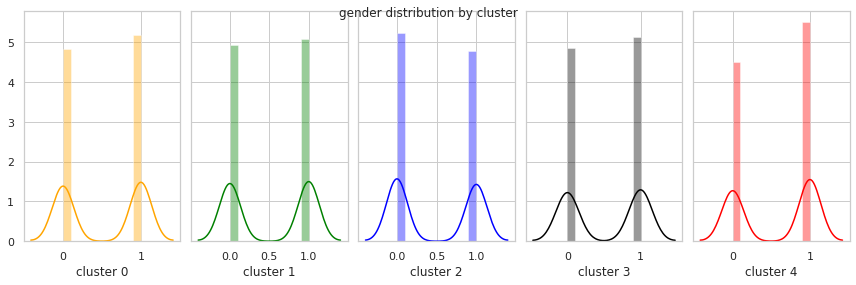

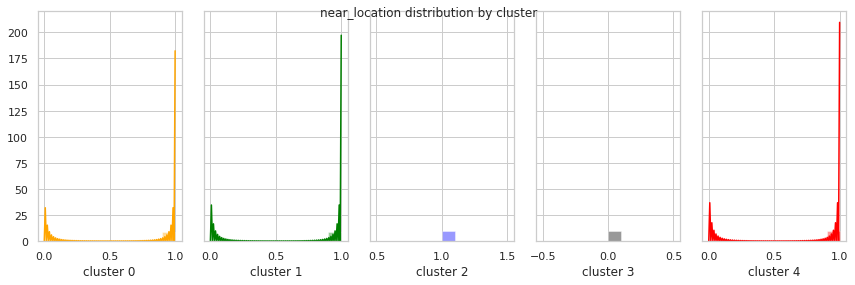

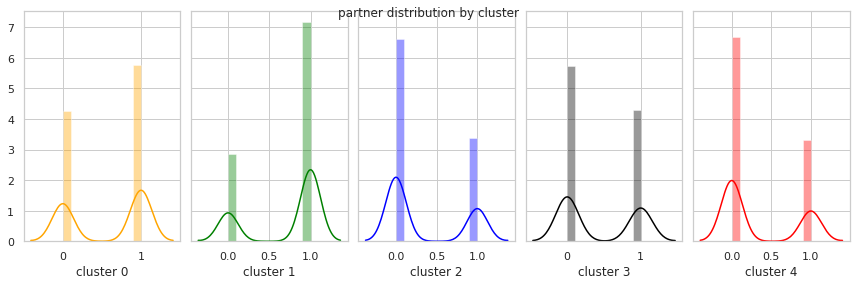

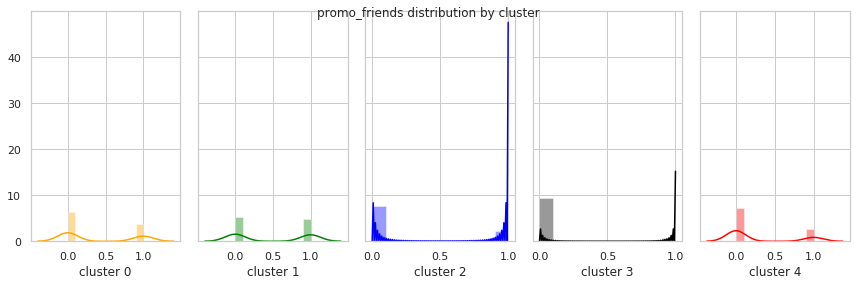

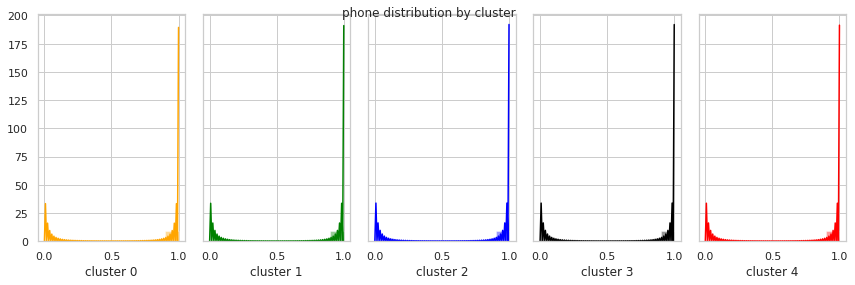

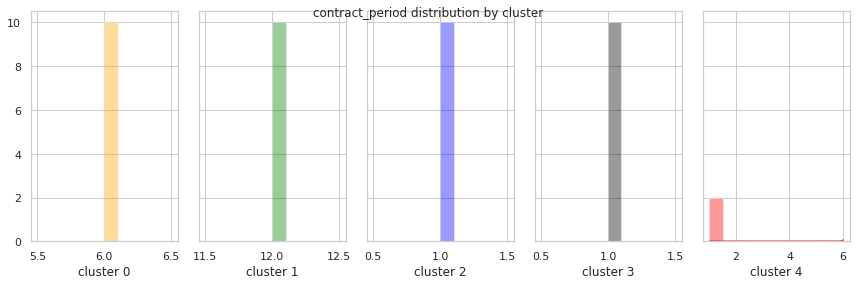

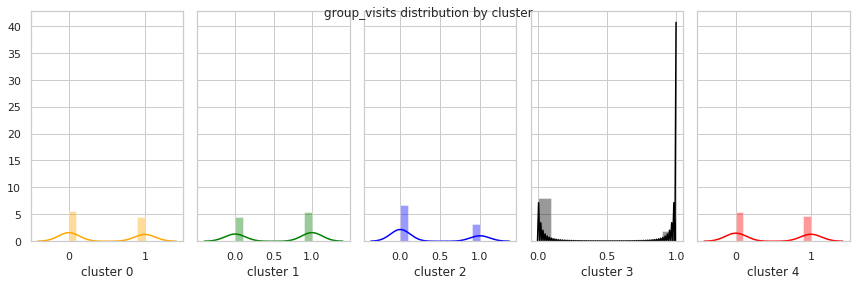

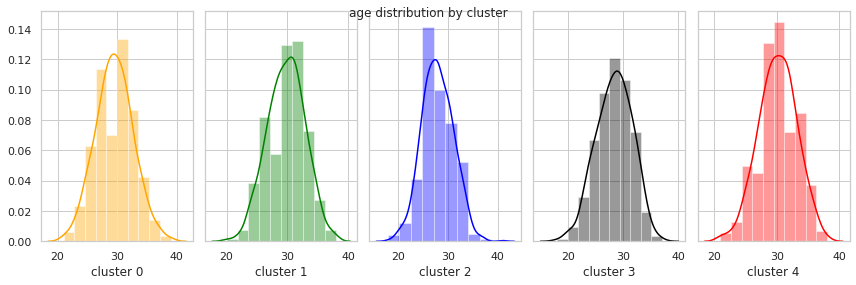

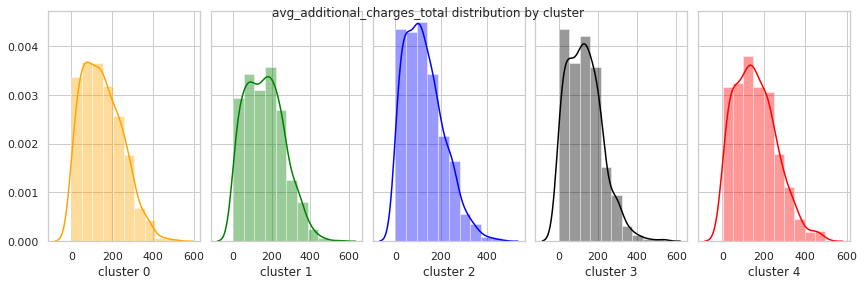

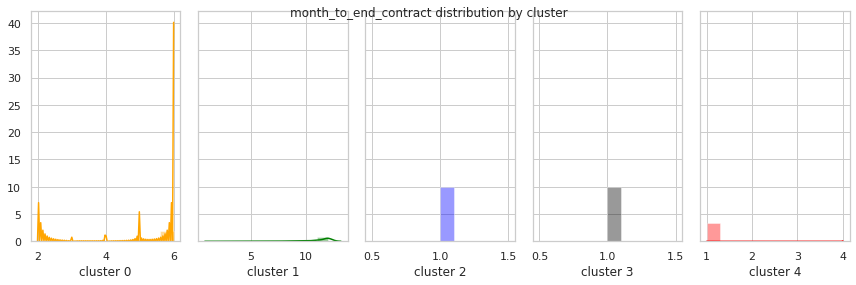

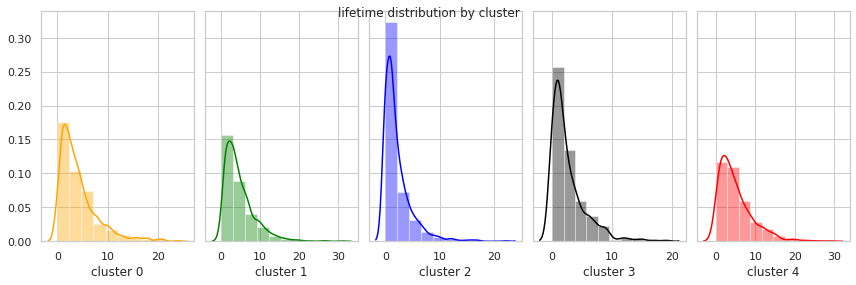

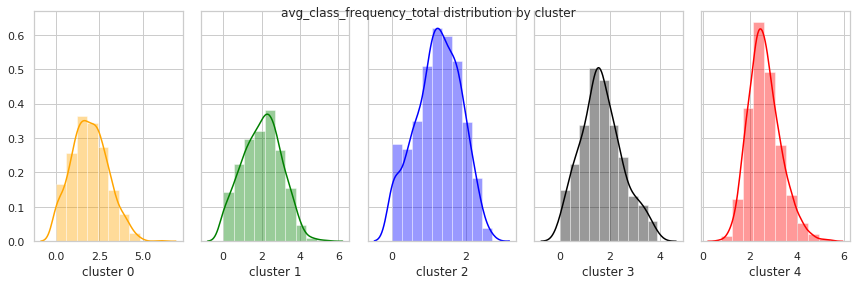

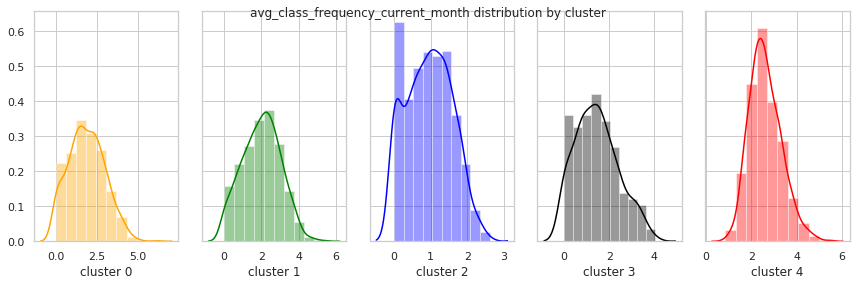

In [49]:
for feature in gym_data.drop(['churn', 'cluster_km'], axis=1).columns:
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
        1, 5, sharey=True, figsize=(12, 4))
    sns.distplot(gym_data.query('cluster_km ==0')[
        feature], bins=10, ax=ax1, color='orange')
    ax1.set_xlabel('cluster 0')

    sns.distplot(gym_data.query('cluster_km ==1')[
        feature], bins=10, ax=ax2, color='green')
    ax2.set_xlabel('cluster 1')


    sns.distplot(gym_data.query('cluster_km ==2')[
        feature], bins=10, ax=ax3, color='blue')
    ax3.set_xlabel('cluster 2')

    sns.distplot(gym_data.query('cluster_km ==3')[
        feature], bins=10, ax=ax4, color='black')
    ax4.set_xlabel('cluster 3')
    
    sns.distplot(gym_data.query('cluster_km ==4')[
        feature], bins=10, ax=ax5, color='red')
    ax5.set_xlabel('cluster 4')

    plt.suptitle(' '.join ([feature, 'distribution by cluster']))
    plt.tight_layout()

As seen from the distribution plots by feature above, we can see that there are not always clear distinction among all the clusters for each feature. For example, for the feature of 'partner', cluster 0, 1 and 4 show similar distributions, whereas cluster 2 and 3 are similar.

Cluster 0 which has the highest churn rate does not always perform the worst in terms of particular features. By worst here we only meant have the lowest of rate of class 1. For example, for the feature of 'promo_friend', it is cluster 4 that has a strikingly high proportion of 0, which means a very high proportion of cluster 4 customers were not brought in through 'bring a friend' promotion.

Both cluster 0 and cluster 4 also, on average, have the shortest contract period, lowest group visit rate, lowest extra charge, shortest lifetime, and lowest frequency of classes per week. Hence, not suprisingly, cluster 0 and cluster 4 have the highest churn rate, at 61% and 52% respectively, in contract to cluster 2's star performance at 2%.

Finally, let's take a look at the mean Silhouette Coefficient of all samples.

In [50]:
silhouette_score(X_sc, labels) 

0.16172718486568516

The value above is positive, but closer to 0 than to 1. This indicates that there might be overlapping clusters. If we take a look at the mean feature values of the clusters, we can notice that the mean values across some features among the clusters are not that far apart.

This might have to do with us arbitrarily determining the 5 clusters, instead of 3 as the dendrogram shows. Out of curiosity, let's see what the score would be like if we have 3 clusters.

In [51]:
km_3 = KMeans(n_clusters = 3, random_state=42)
labels_3 = km_3.fit_predict(X_sc) 
silhouette_score(X_sc, labels_3) 



0.22212259388825822

Yes indeed there is a small improvement.

# Part 5 summary

In this section, we've plot a dendrograms to have identified 3 customer clusters. Then we used the Kmeans method to have divided the customers into 5 clusters and examined the mean feature values by cluster.

What we found out is that cluster 0 and 4 are the most prone to quitting the gym in the following month, whereas cluster 2 is the most loyal among all.

What differs cluster 0 and 4 from cluster 2 centers on the following features:

- low v.s high rate of customers being employees of a partner company;

- low v.s high proportion of customers who signed up through 'bring a friend' offer;

- shortest v.s longest contract period, as well as month to end contract

- lowest v.s highest average frequency of group visits;

- younger v.s older;

- lowest v.s highest additional charge;

- shortest v.s longest lifetime;

- lowest v.s highest weekly class attending frequency

Having identified the clusters and how they differ, as well as how their churn rate differs, we are ready to make some recommendations for the gym.

# Part 6: Findings and conclusions

Drawing on our analysis above, here a a few recommendations for the gym regarding the strategy for customer interaction and retention:

- Given'bring a friend' customers are more likely to be loyal customers, the gym may make a greater effort to promote that plan or activity. For example, if it hasn't been implemented already, gym can reward members who bring a friend with either a free month membership, or free entry to gym competitions, or even a pretty gym bottle.

- Developing more partner companies in the gym neighbourhood may also be an effective strategy to develop loyal customers. The gym staff may actually reach out to companies nearby, offering their employees some attractive starter member package. Being from the same company already gives a sense of community and hence the members are more likely to stay.

- Promoting group class might be another way to retain customers. Again this has to be with building that sense of community. If the members feel they are part of the group and they have friends in the gym to feel they have to be accountable for, they are more likely to stick to the gym. The gym might have an activity such as free class friday, or bring a friend for free class Saturday, to promote the group classes and class attending frequency.

- For the same purpose of community building, the gym may organize events or competitions among its members periodically, such as a 12 week challenge leading to summer, or a 8 week challenge in winter. Having those competitions is a great way to allow members to make friends with one another and build the gym community.

- Finally, the gym can certainly use the algorithm to identify the customers who are likely to quit next month. Although there are factors we can't change, such as their age, employer or if they have joined through a friend, what the gym can do is to, for example, offer them a complimentary personal training session which could also serve as a chance to find out more about their gym use, an opportunity to enter a lucky draw if they attend 2 group class in the next two weeks, or at least to give them a call to find out their experience of using the gym.